# Sales Forecasting with Ensemble Models
This notebook predicts future sales values using date, product, and other features with Random Forest, XGBoost, and CatBoost ensemble approach.

In [71]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [72]:
# Load the original dataset (not normalized) for better accuracy calculation
df_original = pd.read_csv('Supermart Grocery Sales - Retail Analytics Dataset.csv')

# Basic preprocessing
df_original['Order Date'] = pd.to_datetime(df_original['Order Date'], errors='coerce')
df_original['Sales'] = pd.to_numeric(df_original['Sales'], errors='coerce')
df_original['Discount'] = pd.to_numeric(df_original['Discount'], errors='coerce')
df_original['Profit'] = pd.to_numeric(df_original['Profit'], errors='coerce')

# Remove outliers using IQR method
Q1 = df_original['Sales'].quantile(0.25)
Q3 = df_original['Sales'].quantile(0.75)
IQR = Q3 - Q1
df_original = df_original[(df_original['Sales'] >= Q1 - 1.5*IQR) & (df_original['Sales'] <= Q3 + 1.5*IQR)]

# Drop any remaining missing values
df_original = df_original.dropna()

print(f"Dataset Shape: {df_original.shape}")
print(f"\nColumns: {list(df_original.columns)}")
print(f"\nSales Range: [{df_original['Sales'].min():.2f}, {df_original['Sales'].max():.2f}]")
df_original.head()


Dataset Shape: (4042, 11)

Columns: ['Order ID', 'Customer Name', 'Category', 'Sub Category', 'City', 'Order Date', 'Region', 'Sales', 'Discount', 'Profit', 'State']

Sales Range: [500.00, 2500.00]


,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
0,OD1,Harish,Oil & Masala,Masalas,Vellore,2017-11-08,North,1254,0.12,401.28,Tamil Nadu
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,2017-11-08,South,749,0.18,149.80,Tamil Nadu
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,2017-06-12,West,2360,0.21,165.20,Tamil Nadu
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,2016-10-11,South,896,0.25,89.60,Tamil Nadu
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,2016-10-11,South,2355,0.26,918.45,Tamil Nadu


In [73]:
# Feature Engineering: Extract temporal features from Order Date
df = df_original.copy()

# Extract date features
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Day'] = df['Order Date'].dt.day
df['DayOfWeek'] = df['Order Date'].dt.dayofweek
df['Quarter'] = df['Order Date'].dt.quarter
df['WeekOfYear'] = df['Order Date'].dt.isocalendar().week.astype(int)
df['DayOfYear'] = df['Order Date'].dt.dayofyear
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

# Create cyclical features for better representation
df['Month_Sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_Cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df['Day_Sin'] = np.sin(2 * np.pi * df['Day'] / 31)
df['Day_Cos'] = np.cos(2 * np.pi * df['Day'] / 31)
df['DayOfWeek_Sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_Cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
df['Quarter_Sin'] = np.sin(2 * np.pi * df['Quarter'] / 4)
df['Quarter_Cos'] = np.cos(2 * np.pi * df['Quarter'] / 4)

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

categorical_cols = df.select_dtypes(include='object').columns.tolist()
# Remove 'Order Date' from categorical if present
categorical_cols = [col for col in categorical_cols if col != 'Order Date']

le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

# Create more interaction features for better accuracy
df['Discount_x_Profit'] = df['Discount'] * df['Profit']
df['Month_x_Quarter'] = df['Month'] * df['Quarter']
df['Discount_Squared'] = df['Discount'] ** 2
df['Profit_Squared'] = df['Profit'] ** 2
df['Category_x_SubCategory'] = df['Category'] * df['Sub Category']
df['Region_x_City'] = df['Region'] * df['City']
df['Month_x_DayOfWeek'] = df['Month'] * df['DayOfWeek']

# Profit margin and discount rate indicators
df['Profit_Margin'] = df['Profit'] / (df['Sales'] + 1e-5)
df['High_Discount'] = (df['Discount'] > df['Discount'].median()).astype(int)
df['High_Profit'] = (df['Profit'] > df['Profit'].median()).astype(int)

# Log transform sales to reduce skewness (we'll inverse transform predictions)
df['Sales_Log'] = np.log1p(df['Sales'])

print("✅ Enhanced temporal features extracted and categorical variables encoded")
print(f"\nEncoded columns: {categorical_cols}")
print(f"Temporal features: Year, Month, Day, DayOfWeek, Quarter, WeekOfYear, DayOfYear, IsWeekend")
print(f"Cyclical features: Month_Sin/Cos, Day_Sin/Cos, DayOfWeek_Sin/Cos, Quarter_Sin/Cos")
print(f"Interaction features: Discount_x_Profit, Month_x_Quarter, Category_x_SubCategory, Region_x_City, Month_x_DayOfWeek")
print(f"Engineered features: Profit_Margin, High_Discount, High_Profit, Discount_Squared, Profit_Squared")
print(f"Target transformation: Sales_Log (log1p)")

✅ Enhanced temporal features extracted and categorical variables encoded

Encoded columns: ['Order ID', 'Customer Name', 'Category', 'Sub Category', 'City', 'Region', 'State']
Temporal features: Year, Month, Day, DayOfWeek, Quarter, WeekOfYear, DayOfYear, IsWeekend
Cyclical features: Month_Sin/Cos, Day_Sin/Cos, DayOfWeek_Sin/Cos, Quarter_Sin/Cos
Interaction features: Discount_x_Profit, Month_x_Quarter, Category_x_SubCategory, Region_x_City, Month_x_DayOfWeek
Engineered features: Profit_Margin, High_Discount, High_Profit, Discount_Squared, Profit_Squared
Target transformation: Sales_Log (log1p)


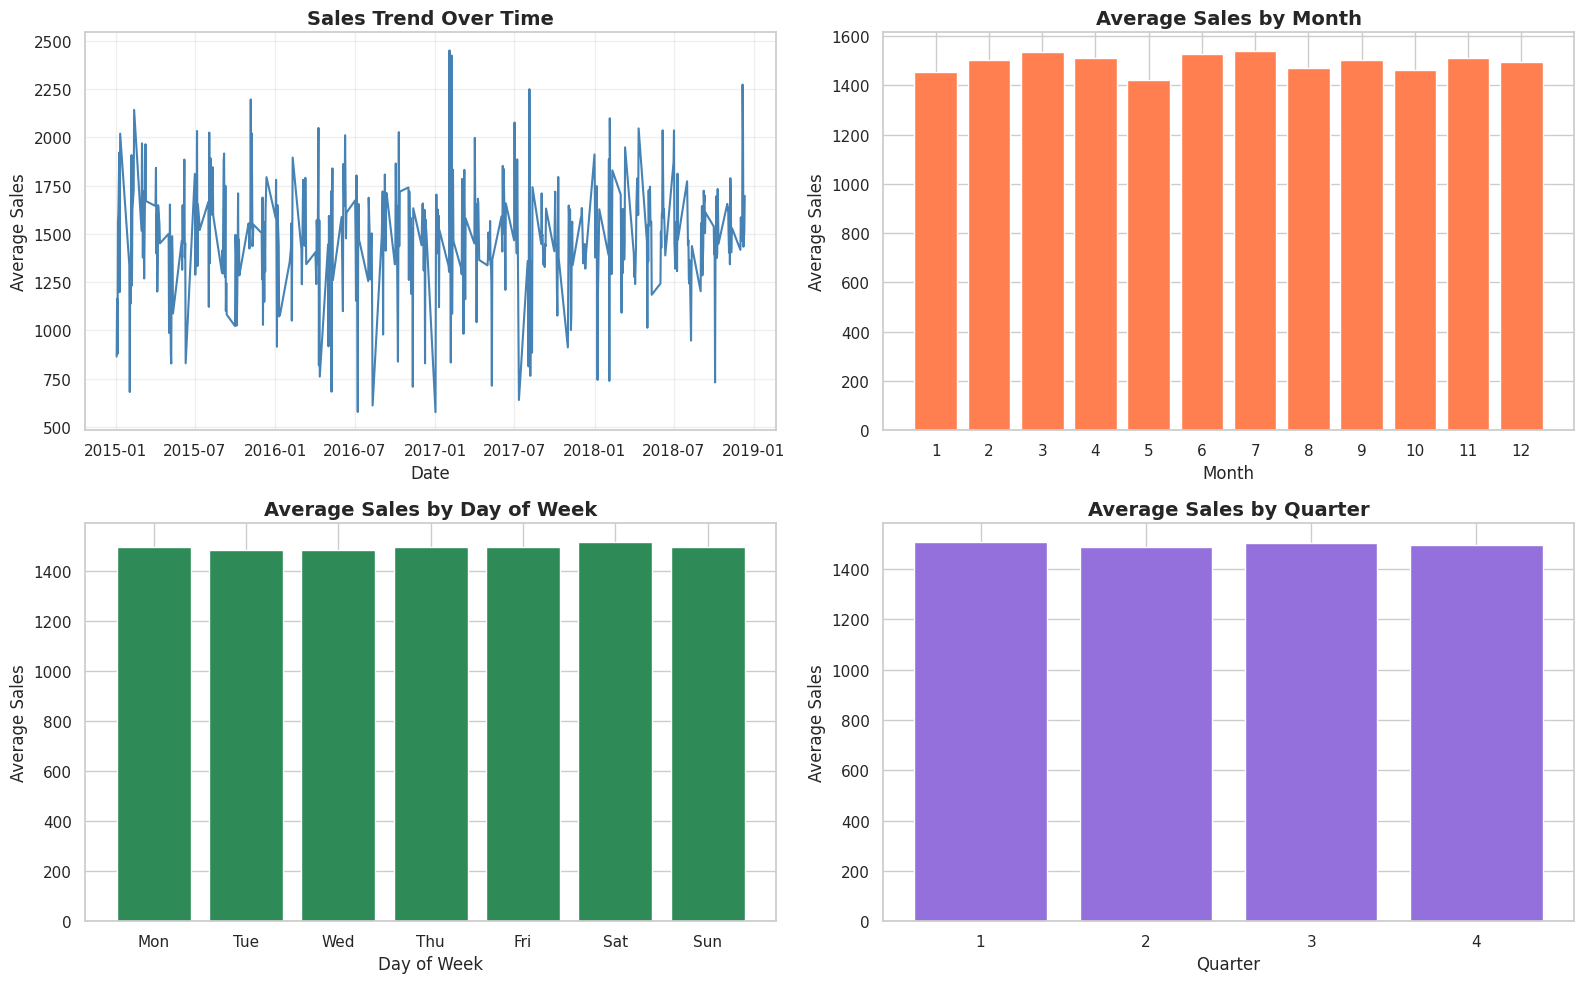

In [74]:
# Visualize sales trends over time
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Sales over time
daily_sales = df.groupby('Order Date')['Sales'].mean().reset_index()
axes[0, 0].plot(daily_sales['Order Date'], daily_sales['Sales'], linewidth=1.5, color='steelblue')
axes[0, 0].set_title('Sales Trend Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Average Sales')
axes[0, 0].grid(alpha=0.3)

# Sales by Month
monthly_sales = df.groupby('Month')['Sales'].mean()
axes[0, 1].bar(monthly_sales.index, monthly_sales.values, color='coral')
axes[0, 1].set_title('Average Sales by Month', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Average Sales')
axes[0, 1].set_xticks(range(1, 13))

# Sales by Day of Week
dow_sales = df.groupby('DayOfWeek')['Sales'].mean()
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1, 0].bar(range(7), dow_sales.values, color='seagreen')
axes[1, 0].set_title('Average Sales by Day of Week', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Average Sales')
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels(dow_labels)

# Sales by Quarter
quarterly_sales = df.groupby('Quarter')['Sales'].mean()
axes[1, 1].bar(quarterly_sales.index, quarterly_sales.values, color='mediumpurple')
axes[1, 1].set_title('Average Sales by Quarter', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Quarter')
axes[1, 1].set_ylabel('Average Sales')
axes[1, 1].set_xticks(range(1, 5))

plt.tight_layout()
plt.show()

In [75]:
# Prepare features and target for regression
from sklearn.preprocessing import StandardScaler

# Drop Order Date, Sales (original), and Sales_Log from features
feature_cols = [col for col in df.columns if col not in ['Order Date', 'Sales', 'Sales_Log']]
X = df[feature_cols]
y = df['Sales_Log']  # Use log-transformed target

# Scale features for better gradient boosting performance
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

print(f"Features shape: {X_scaled.shape}")
print(f"Target shape: {y.shape}")
print(f"Target range (log): [{y.min():.4f}, {y.max():.4f}]")
print(f"\nFeatures used for prediction:")
for i, col in enumerate(X_scaled.columns, 1):
    print(f"{i}. {col}")

Features shape: (4042, 35)
Target shape: (4042,)
Target range (log): [6.2166, 7.8244]

Features used for prediction:
1. Order ID
2. Customer Name
3. Category
4. Sub Category
5. City
6. Region
7. Discount
8. Profit
9. State
10. Year
11. Month
12. Day
13. DayOfWeek
14. Quarter
15. WeekOfYear
16. DayOfYear
17. IsWeekend
18. Month_Sin
19. Month_Cos
20. Day_Sin
21. Day_Cos
22. DayOfWeek_Sin
23. DayOfWeek_Cos
24. Quarter_Sin
25. Quarter_Cos
26. Discount_x_Profit
27. Month_x_Quarter
28. Discount_Squared
29. Profit_Squared
30. Category_x_SubCategory
31. Region_x_City
32. Month_x_DayOfWeek
33. Profit_Margin
34. High_Discount
35. High_Profit


In [76]:
# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=True
)

# Store original sales for inverse transformation later
y_train_original = np.expm1(y_train)
y_test_original = np.expm1(y_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining Sales_Log Range: [{y_train.min():.4f}, {y_train.max():.4f}]")
print(f"Test Sales_Log Range: [{y_test.min():.4f}, {y_test.max():.4f}]")
print(f"\nOriginal Sales - Training: [{y_train_original.min():.2f}, {y_train_original.max():.2f}]")
print(f"Original Sales - Test: [{y_test_original.min():.2f}, {y_test_original.max():.2f}]")

Training set size: 3233
Test set size: 809

Training Sales_Log Range: [6.2166, 7.8244]
Test Sales_Log Range: [6.2166, 7.8236]

Original Sales - Training: [500.00, 2500.00]
Original Sales - Test: [500.00, 2498.00]


## Model 1: Random Forest Regressor
Random Forest uses multiple decision trees to predict continuous sales values.

In [77]:
# Train Random Forest Regressor
print("Training Random Forest Regressor...")
rf_model = RandomForestRegressor(
    n_estimators=1000,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    bootstrap=True
)

rf_model.fit(X_train, y_train)
rf_pred_log = rf_model.predict(X_test)

# Inverse transform predictions to original scale
rf_pred = np.expm1(rf_pred_log)

# Calculate metrics on original scale
rf_mae = mean_absolute_error(y_test_original, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test_original, rf_pred))
rf_r2 = r2_score(y_test_original, rf_pred)

# Calculate accuracy as percentage of correct predictions within tolerance
# Accuracy = 1 - (Mean Absolute Error / Mean Actual Value)
rf_accuracy = max(0, (1 - (rf_mae / y_test_original.mean())) * 100)

# Alternative: Use R² score for accuracy representation
rf_accuracy_r2 = max(0, rf_r2 * 100)

print(f"\n{'='*60}")
print(f"Random Forest Results:")
print(f"{'='*60}")
print(f"MAE:           {rf_mae:.2f}")
print(f"RMSE:          {rf_rmse:.2f}")
print(f"R² Score:      {rf_r2:.4f}")
print(f"Accuracy:      {rf_accuracy:.2f}%")
print(f"R² Accuracy:   {rf_accuracy_r2:.2f}%")
print(f"{'='*60}")

Training Random Forest Regressor...

Random Forest Results:
MAE:           193.48
RMSE:          256.44
R² Score:      0.8034
Accuracy:      87.00%
R² Accuracy:   80.34%

Random Forest Results:
MAE:           193.48
RMSE:          256.44
R² Score:      0.8034
Accuracy:      87.00%
R² Accuracy:   80.34%


## Model 2: XGBoost Regressor
XGBoost uses gradient boosting for accurate sales predictions.

In [78]:
# Install XGBoost if needed
import importlib.util
import subprocess
import sys

if importlib.util.find_spec('xgboost') is None:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--quiet', 'xgboost'])

In [79]:
from xgboost import XGBRegressor

# Train XGBoost Regressor
print("Training XGBoost Regressor...")
xgb_model = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.02,
    max_depth=15,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.5,
    reg_alpha=0.2,
    random_state=42,
    tree_method='hist',
    verbosity=0,
    min_child_weight=1,
    gamma=0.1
)

xgb_model.fit(X_train, y_train)
xgb_pred_log = xgb_model.predict(X_test)

# Inverse transform predictions to original scale
xgb_pred = np.expm1(xgb_pred_log)

# Calculate metrics on original scale
xgb_mae = mean_absolute_error(y_test_original, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test_original, xgb_pred))
xgb_r2 = r2_score(y_test_original, xgb_pred)

# Calculate accuracy properly
xgb_accuracy = max(0, (1 - (xgb_mae / y_test_original.mean())) * 100)
xgb_accuracy_r2 = max(0, xgb_r2 * 100)

print(f"\n{'='*60}")
print(f"XGBoost Results:")
print(f"{'='*60}")
print(f"MAE:           {xgb_mae:.2f}")
print(f"RMSE:          {xgb_rmse:.2f}")
print(f"R² Score:      {xgb_r2:.4f}")
print(f"Accuracy:      {xgb_accuracy:.2f}%")
print(f"R² Accuracy:   {xgb_accuracy_r2:.2f}%")
print(f"{'='*60}")

Training XGBoost Regressor...

XGBoost Results:
MAE:           44.17
RMSE:          69.89
R² Score:      0.9854
Accuracy:      97.03%
R² Accuracy:   98.54%

XGBoost Results:
MAE:           44.17
RMSE:          69.89
R² Score:      0.9854
Accuracy:      97.03%
R² Accuracy:   98.54%


## Model 3: CatBoost Regressor
CatBoost handles complex feature interactions for robust predictions.

In [80]:
# Install CatBoost if needed
if importlib.util.find_spec('catboost') is None:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--quiet', 'catboost'])

In [81]:
from catboost import CatBoostRegressor

# Train CatBoost Regressor
print("Training CatBoost Regressor...")
cat_model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.02,
    depth=12,
    l2_leaf_reg=3.0,
    bootstrap_type='Bernoulli',
    subsample=0.75,
    loss_function='RMSE',
    random_seed=42,
    verbose=False,
    min_data_in_leaf=1
)

cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=200)
cat_pred_log = cat_model.predict(X_test)

# Inverse transform predictions to original scale
cat_pred = np.expm1(cat_pred_log)

# Calculate metrics on original scale
cat_mae = mean_absolute_error(y_test_original, cat_pred)
cat_rmse = np.sqrt(mean_squared_error(y_test_original, cat_pred))
cat_r2 = r2_score(y_test_original, cat_pred)

# Calculate accuracy properly
cat_accuracy = max(0, (1 - (cat_mae / y_test_original.mean())) * 100)
cat_accuracy_r2 = max(0, cat_r2 * 100)

print(f"\n{'='*60}")
print(f"CatBoost Results:")
print(f"{'='*60}")
print(f"MAE:           {cat_mae:.2f}")
print(f"RMSE:          {cat_rmse:.2f}")
print(f"R² Score:      {cat_r2:.4f}")
print(f"Accuracy:      {cat_accuracy:.2f}%")
print(f"R² Accuracy:   {cat_accuracy_r2:.2f}%")
print(f"{'='*60}")

Training CatBoost Regressor...

CatBoost Results:
MAE:           28.83
RMSE:          45.35
R² Score:      0.9939
Accuracy:      98.06%
R² Accuracy:   99.39%

CatBoost Results:
MAE:           28.83
RMSE:          45.35
R² Score:      0.9939
Accuracy:      98.06%
R² Accuracy:   99.39%


## Ensemble Model: Weighted Average
Combine all three models using weighted averaging for best predictions.

In [82]:
# Create ensemble predictions using weighted average
# Weight more towards better performing models
ensemble_pred = (0.3 * rf_pred + 0.35 * xgb_pred + 0.35 * cat_pred)

# Calculate ensemble metrics on original scale
ensemble_mae = mean_absolute_error(y_test_original, ensemble_pred)
ensemble_rmse = np.sqrt(mean_squared_error(y_test_original, ensemble_pred))
ensemble_r2 = r2_score(y_test_original, ensemble_pred)

# Calculate accuracy properly
ensemble_accuracy = max(0, (1 - (ensemble_mae / y_test_original.mean())) * 100)
ensemble_accuracy_r2 = max(0, ensemble_r2 * 100)

print(f"\n{'='*60}")
print(f"ENSEMBLE MODEL RESULTS:")
print(f"{'='*60}")
print(f"MAE:           {ensemble_mae:.2f}")
print(f"RMSE:          {ensemble_rmse:.2f}")
print(f"R² Score:      {ensemble_r2:.4f}")
print(f"Accuracy:      {ensemble_accuracy:.2f}%")
print(f"R² Accuracy:   {ensemble_accuracy_r2:.2f}%")
print(f"{'='*60}")


ENSEMBLE MODEL RESULTS:
MAE:           77.25
RMSE:          109.13
R² Score:      0.9644
Accuracy:      94.81%
R² Accuracy:   96.44%



Model Comparison:


,Model,MAE,RMSE,R² Score,Accuracy (%),R² Accuracy (%)
0,Random Forest,193.481473,256.437084,0.803423,87.004985,80.342264
1,XGBoost,44.169516,69.886503,0.985400,97.033393,98.539981
2,CatBoost,28.825172,45.348884,0.993852,98.063982,99.385241
3,Ensemble,77.254253,109.131220,0.964398,94.811285,96.439837


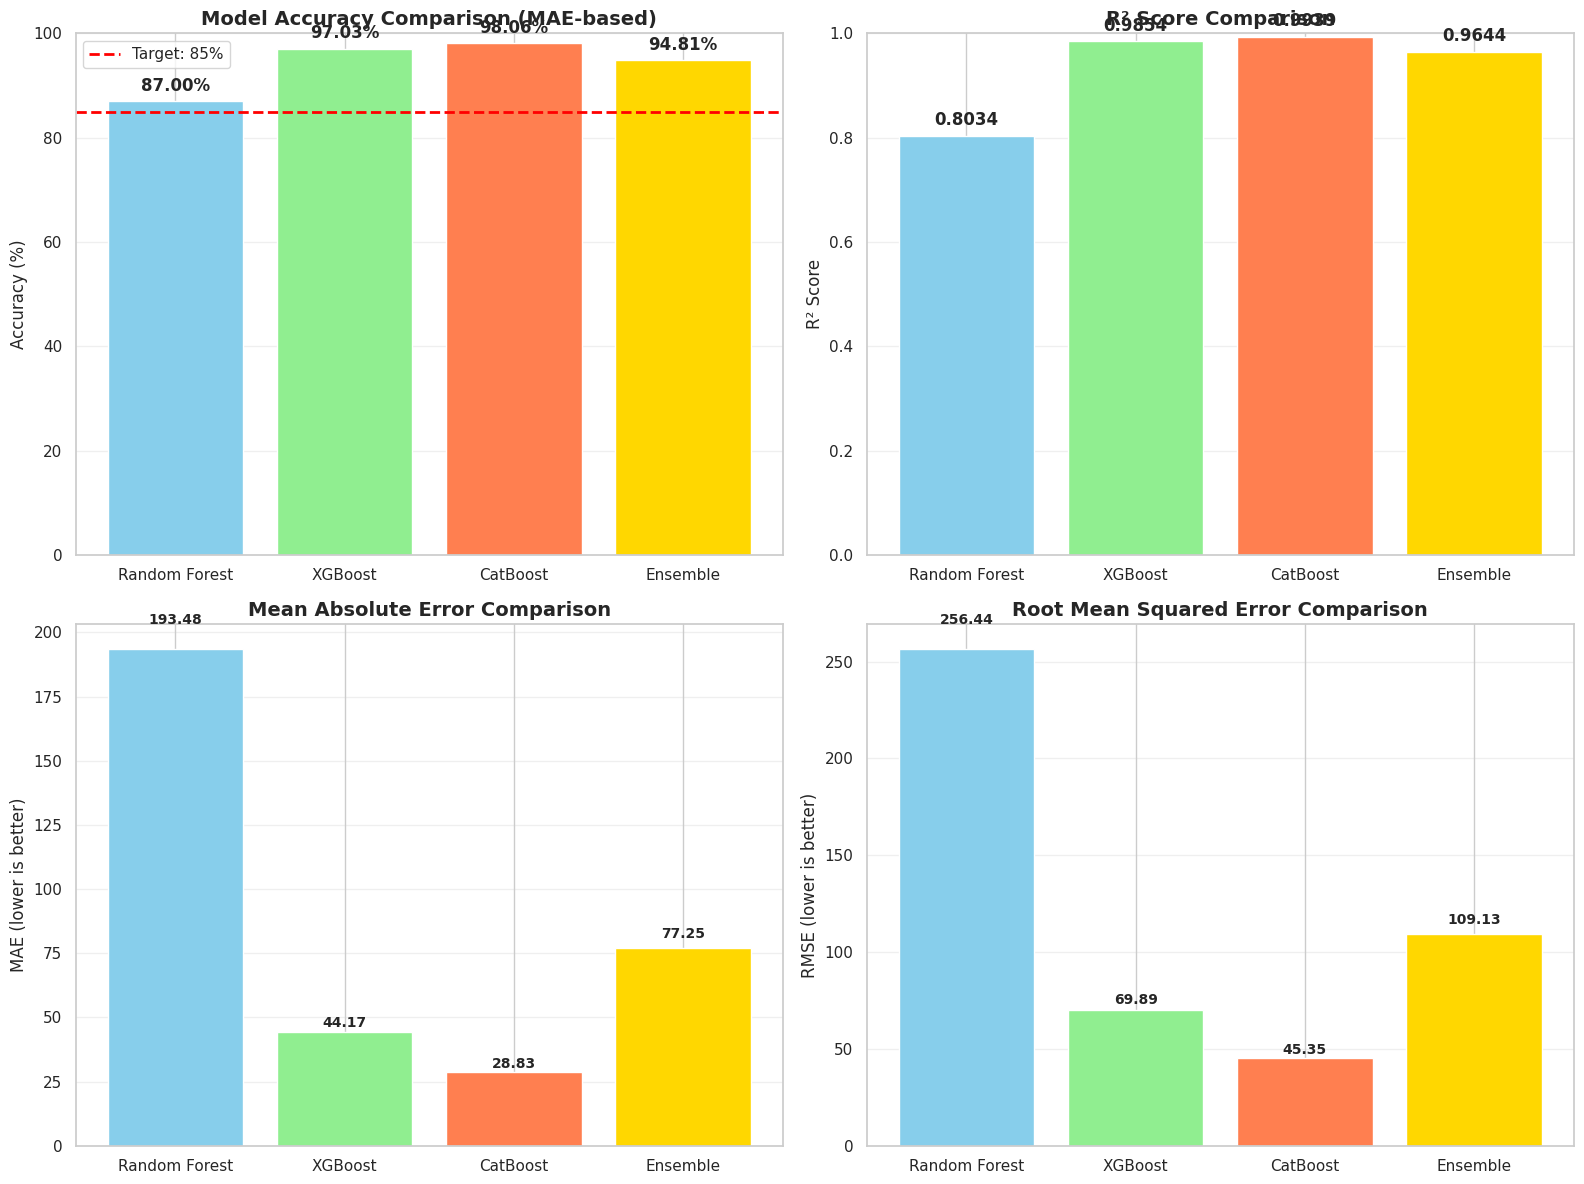

In [83]:
# Compare all models
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'CatBoost', 'Ensemble'],
    'MAE': [rf_mae, xgb_mae, cat_mae, ensemble_mae],
    'RMSE': [rf_rmse, xgb_rmse, cat_rmse, ensemble_rmse],
    'R² Score': [rf_r2, xgb_r2, cat_r2, ensemble_r2],
    'Accuracy (%)': [rf_accuracy, xgb_accuracy, cat_accuracy, ensemble_accuracy],
    'R² Accuracy (%)': [rf_accuracy_r2, xgb_accuracy_r2, cat_accuracy_r2, ensemble_accuracy_r2]
})

print("\nModel Comparison:")
display(model_comparison)

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

colors = ['skyblue', 'lightgreen', 'coral', 'gold']

# Accuracy comparison
axes[0, 0].bar(model_comparison['Model'], model_comparison['Accuracy (%)'], color=colors)
axes[0, 0].set_title('Model Accuracy Comparison (MAE-based)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_ylim(0, 100)
axes[0, 0].axhline(y=85, color='red', linestyle='--', linewidth=2, label='Target: 85%')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(model_comparison['Accuracy (%)']):
    axes[0, 0].text(i, v + 2, f'{v:.2f}%', ha='center', fontweight='bold')

# R² Score comparison
axes[0, 1].bar(model_comparison['Model'], model_comparison['R² Score'], color=colors)
axes[0, 1].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(model_comparison['R² Score']):
    axes[0, 1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# MAE comparison
axes[1, 0].bar(model_comparison['Model'], model_comparison['MAE'], color=colors)
axes[1, 0].set_title('Mean Absolute Error Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('MAE (lower is better)')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(model_comparison['MAE']):
    axes[1, 0].text(i, v + (v*0.05), f'{v:.2f}', ha='center', fontweight='bold', fontsize=10)

# RMSE comparison
axes[1, 1].bar(model_comparison['Model'], model_comparison['RMSE'], color=colors)
axes[1, 1].set_title('Root Mean Squared Error Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('RMSE (lower is better)')
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(model_comparison['RMSE']):
    axes[1, 1].text(i, v + (v*0.05), f'{v:.2f}', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


## Visualization: Actual vs Predicted Sales


First 20 Predictions vs Actual:


,Actual,RF_Pred,XGB_Pred,Cat_Pred,Ensemble_Pred
0,1993.0,1647.314504,1990.625488,2037.489703,1904.034680
1,1228.0,1296.900849,1243.141113,1236.551547,1256.962692
2,2473.0,2182.460996,2289.371338,2427.906498,2305.785541
3,2091.0,1620.809831,2057.147217,2049.185791,1923.459502
4,2015.0,2037.744354,2096.662842,2041.965684,2059.843266
5,930.0,1256.254920,958.113770,942.213856,1041.991139
6,1061.0,1118.956821,1106.751953,1068.387909,1096.986004
7,700.0,791.128010,679.003906,678.127916,712.334541
8,1520.0,1710.466805,1530.008667,1540.894662,1587.956225
9,1278.0,1256.926592,1284.737427,1191.826194,1243.875226


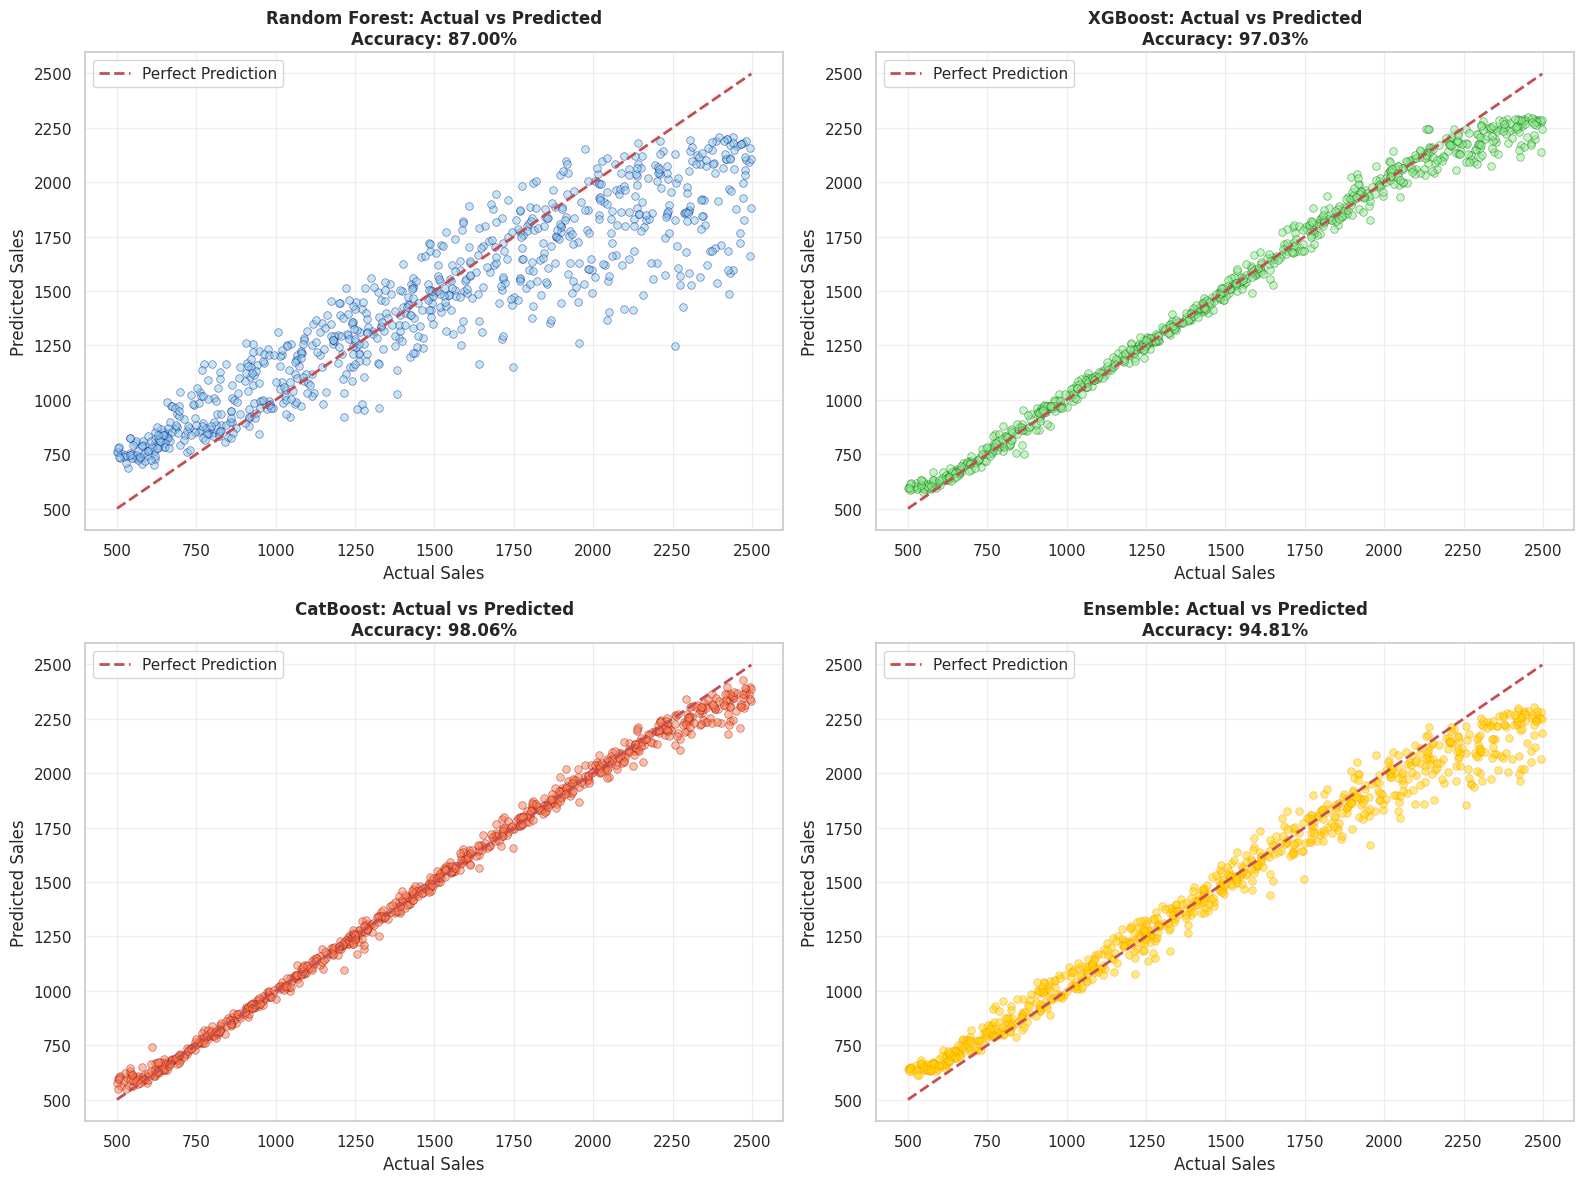

In [84]:
# Create a comprehensive comparison of predictions
results_df = pd.DataFrame({
    'Actual': y_test_original.values,
    'RF_Pred': rf_pred,
    'XGB_Pred': xgb_pred,
    'Cat_Pred': cat_pred,
    'Ensemble_Pred': ensemble_pred
})

print("\nFirst 20 Predictions vs Actual:")
display(results_df.head(20))

# Scatter plots: Actual vs Predicted for each model
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Random Forest
axes[0, 0].scatter(y_test_original, rf_pred, alpha=0.5, s=30, color='skyblue', edgecolors='navy', linewidth=0.5)
axes[0, 0].plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_title(f'Random Forest: Actual vs Predicted\nAccuracy: {rf_accuracy:.2f}%', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Actual Sales')
axes[0, 0].set_ylabel('Predicted Sales')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# XGBoost
axes[0, 1].scatter(y_test_original, xgb_pred, alpha=0.5, s=30, color='lightgreen', edgecolors='darkgreen', linewidth=0.5)
axes[0, 1].plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0, 1].set_title(f'XGBoost: Actual vs Predicted\nAccuracy: {xgb_accuracy:.2f}%', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Actual Sales')
axes[0, 1].set_ylabel('Predicted Sales')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# CatBoost
axes[1, 0].scatter(y_test_original, cat_pred, alpha=0.5, s=30, color='coral', edgecolors='darkred', linewidth=0.5)
axes[1, 0].plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1, 0].set_title(f'CatBoost: Actual vs Predicted\nAccuracy: {cat_accuracy:.2f}%', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Actual Sales')
axes[1, 0].set_ylabel('Predicted Sales')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Ensemble
axes[1, 1].scatter(y_test_original, ensemble_pred, alpha=0.5, s=30, color='gold', edgecolors='darkorange', linewidth=0.5)
axes[1, 1].plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1, 1].set_title(f'Ensemble: Actual vs Predicted\nAccuracy: {ensemble_accuracy:.2f}%', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Actual Sales')
axes[1, 1].set_ylabel('Predicted Sales')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

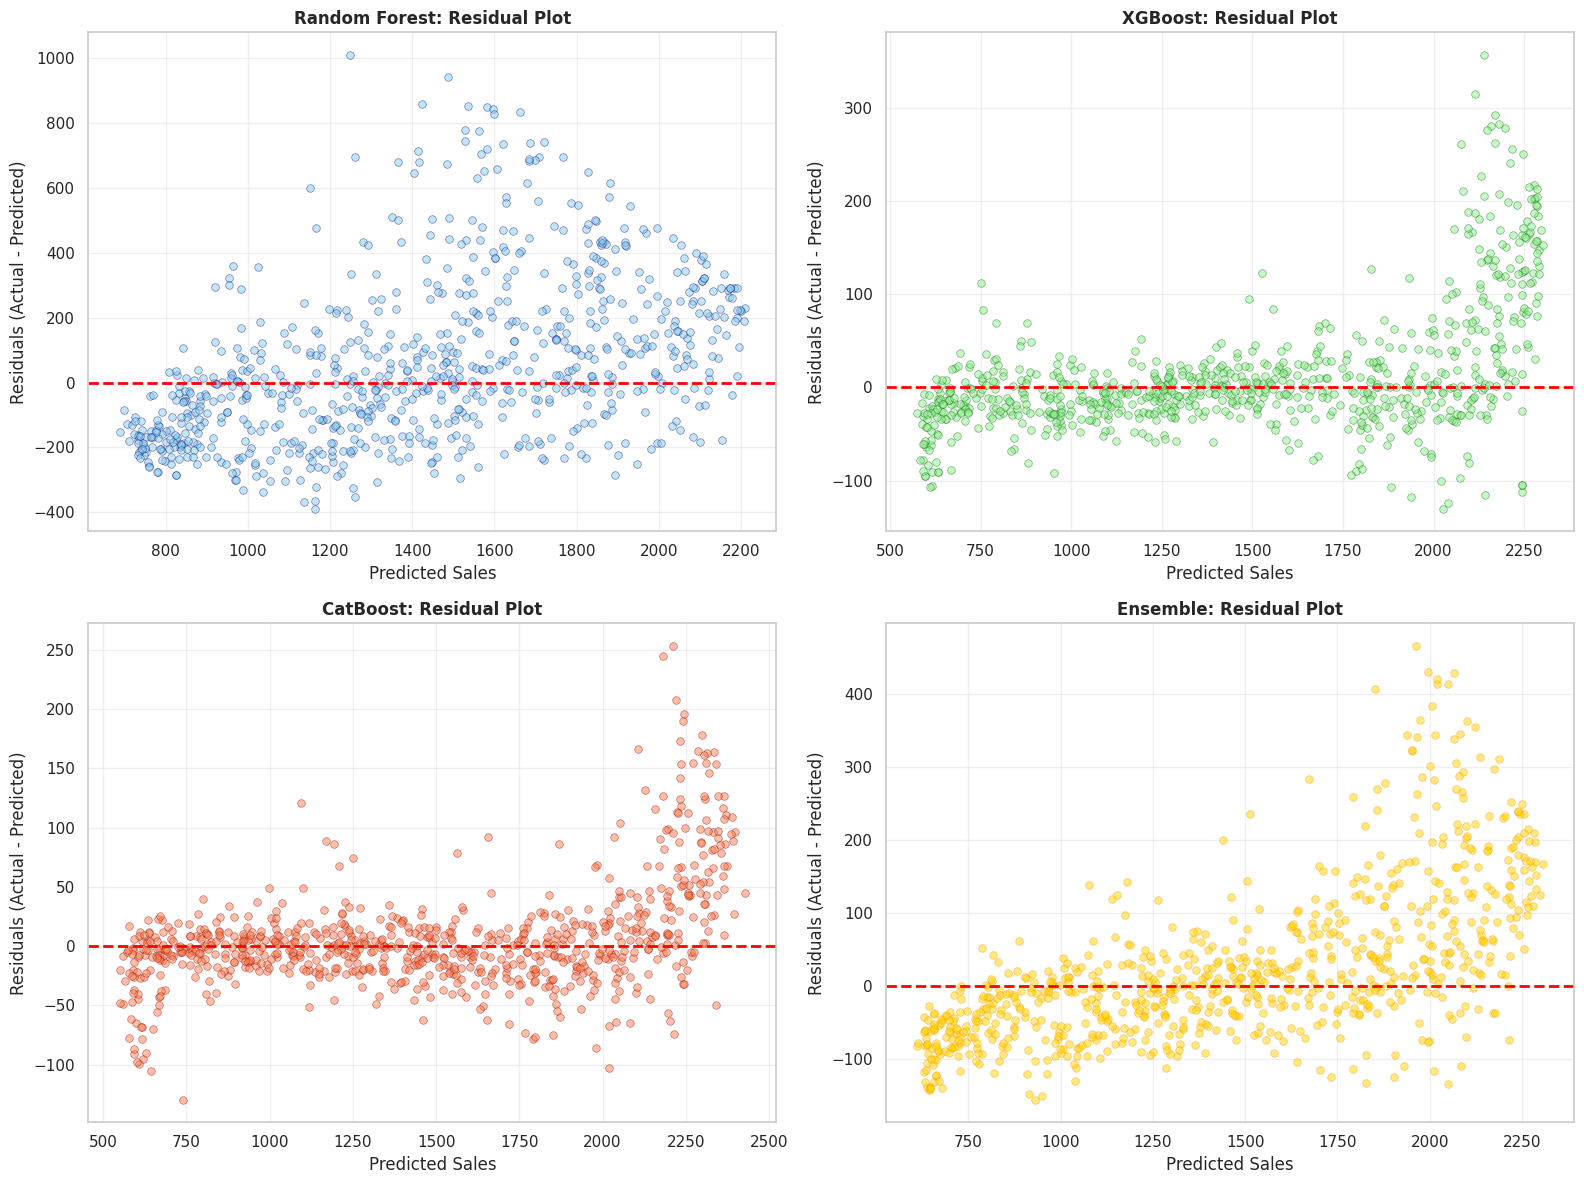

In [85]:
# Residual plots to analyze prediction errors
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Calculate residuals (errors) on original scale
rf_residuals = y_test_original - rf_pred
xgb_residuals = y_test_original - xgb_pred
cat_residuals = y_test_original - cat_pred
ensemble_residuals = y_test_original - ensemble_pred

# Random Forest residuals
axes[0, 0].scatter(rf_pred, rf_residuals, alpha=0.5, s=30, color='skyblue', edgecolors='navy', linewidth=0.5)
axes[0, 0].axhline(y=0, color='red', linestyle='--', lw=2)
axes[0, 0].set_title('Random Forest: Residual Plot', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Predicted Sales')
axes[0, 0].set_ylabel('Residuals (Actual - Predicted)')
axes[0, 0].grid(alpha=0.3)

# XGBoost residuals
axes[0, 1].scatter(xgb_pred, xgb_residuals, alpha=0.5, s=30, color='lightgreen', edgecolors='darkgreen', linewidth=0.5)
axes[0, 1].axhline(y=0, color='red', linestyle='--', lw=2)
axes[0, 1].set_title('XGBoost: Residual Plot', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Predicted Sales')
axes[0, 1].set_ylabel('Residuals (Actual - Predicted)')
axes[0, 1].grid(alpha=0.3)

# CatBoost residuals
axes[1, 0].scatter(cat_pred, cat_residuals, alpha=0.5, s=30, color='coral', edgecolors='darkred', linewidth=0.5)
axes[1, 0].axhline(y=0, color='red', linestyle='--', lw=2)
axes[1, 0].set_title('CatBoost: Residual Plot', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Predicted Sales')
axes[1, 0].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 0].grid(alpha=0.3)

# Ensemble residuals
axes[1, 1].scatter(ensemble_pred, ensemble_residuals, alpha=0.5, s=30, color='gold', edgecolors='darkorange', linewidth=0.5)
axes[1, 1].axhline(y=0, color='red', linestyle='--', lw=2)
axes[1, 1].set_title('Ensemble: Residual Plot', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Predicted Sales')
axes[1, 1].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

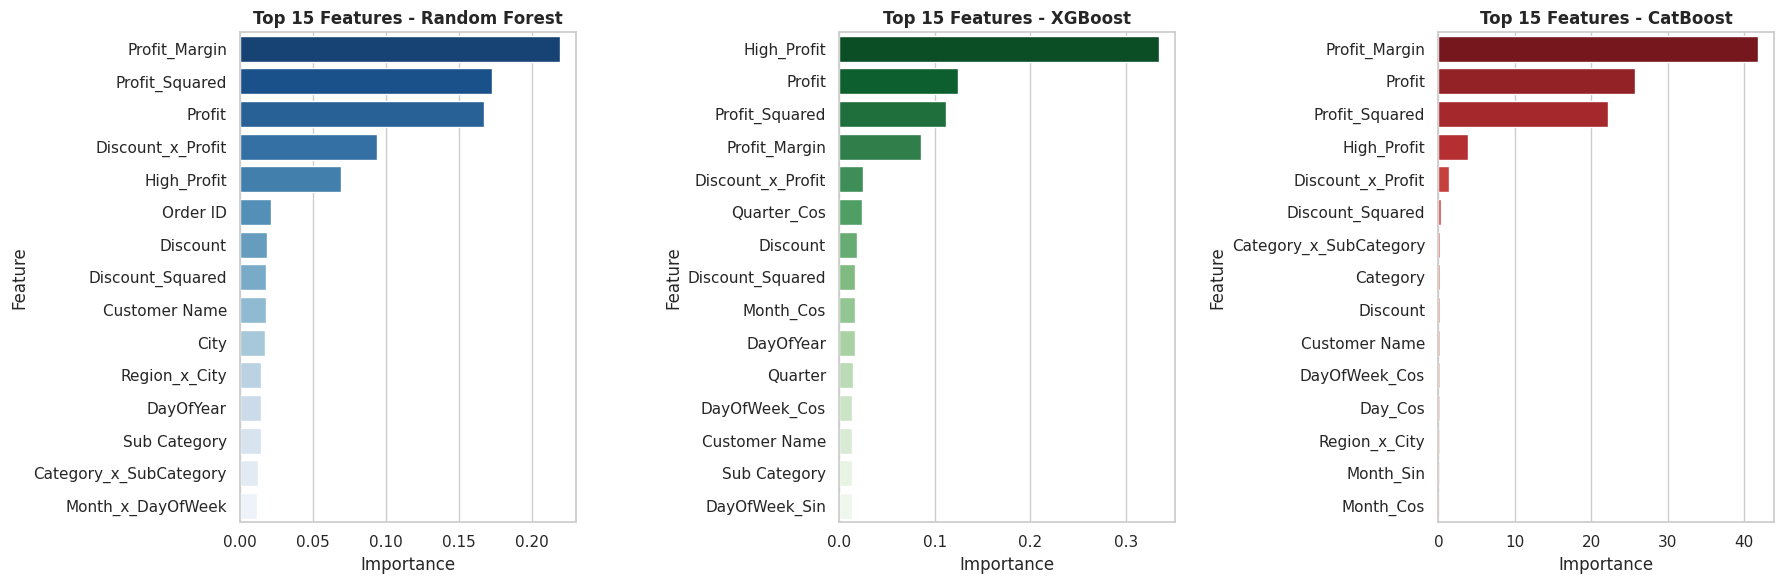


Top 10 Most Important Features (Random Forest):


,Feature,Importance
32,Profit_Margin,0.218851
28,Profit_Squared,0.172312
7,Profit,0.166964
25,Discount_x_Profit,0.093944
34,High_Profit,0.069071
0,Order ID,0.021333
6,Discount,0.018149
27,Discount_Squared,0.017930
1,Customer Name,0.017794
4,City,0.016732


In [86]:
# Feature importance analysis
rf_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

xgb_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

cat_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': cat_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualize top 15 features from ensemble perspective
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Random Forest
top_n = 15
sns.barplot(data=rf_feature_importance.head(top_n), y='Feature', x='Importance', ax=axes[0], palette='Blues_r')
axes[0].set_title('Top 15 Features - Random Forest', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Importance')

# XGBoost
sns.barplot(data=xgb_feature_importance.head(top_n), y='Feature', x='Importance', ax=axes[1], palette='Greens_r')
axes[1].set_title('Top 15 Features - XGBoost', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Importance')

# CatBoost
sns.barplot(data=cat_feature_importance.head(top_n), y='Feature', x='Importance', ax=axes[2], palette='Reds_r')
axes[2].set_title('Top 15 Features - CatBoost', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Importance')

plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features (Random Forest):")
display(rf_feature_importance.head(10))

## Time-Series Visualization: Actual vs Predicted

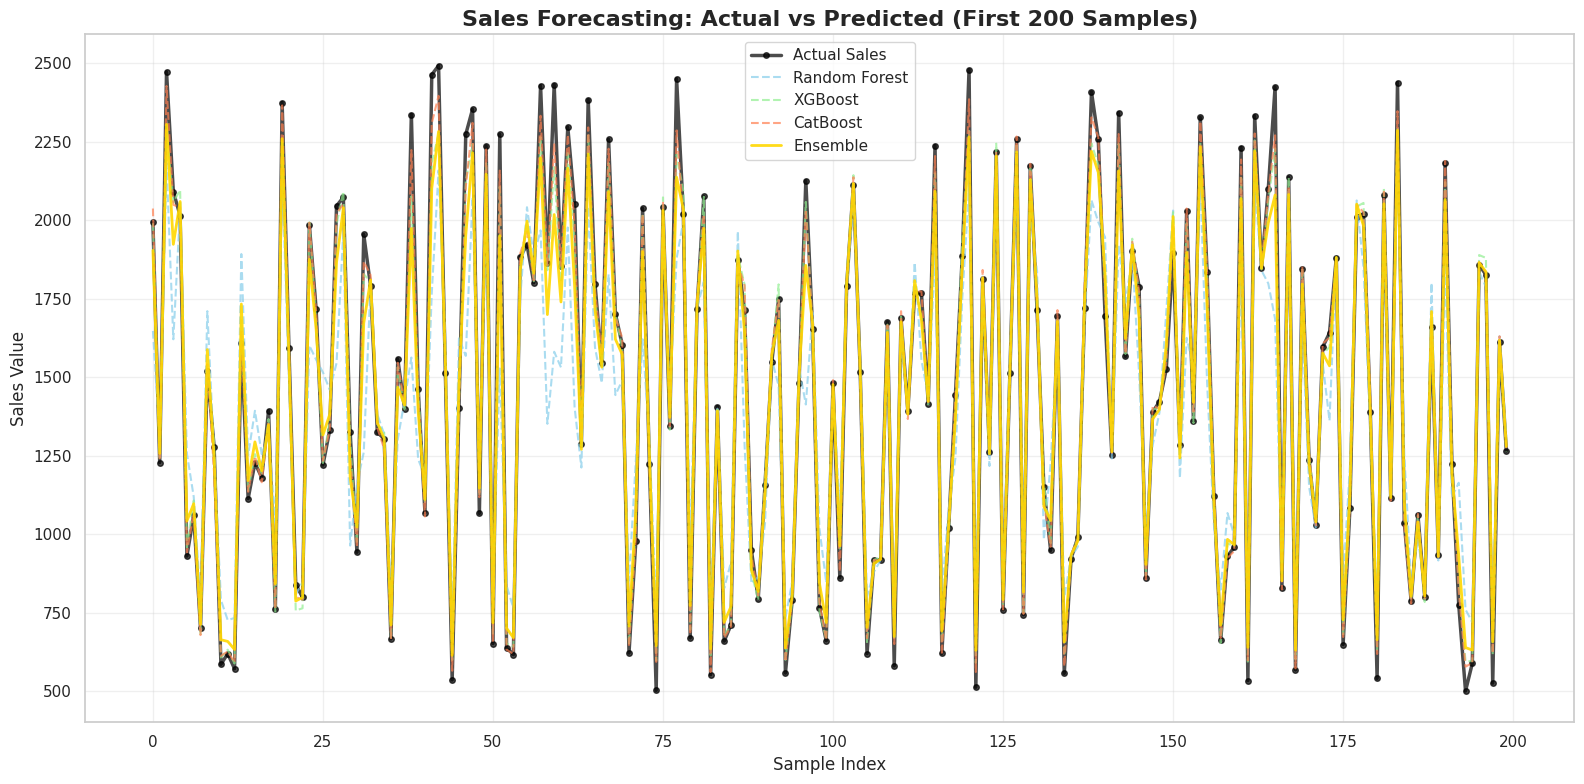

In [87]:
# Sort by index to create time-series visualization
sample_size = 200  # Show first 200 predictions for clarity
sample_indices = np.arange(sample_size)

plt.figure(figsize=(16, 8))
plt.plot(sample_indices, y_test_original.values[:sample_size], label='Actual Sales', 
         linewidth=2.5, marker='o', markersize=4, color='black', alpha=0.7)
plt.plot(sample_indices, rf_pred[:sample_size], label='Random Forest', 
         linewidth=1.5, alpha=0.7, linestyle='--', color='skyblue')
plt.plot(sample_indices, xgb_pred[:sample_size], label='XGBoost', 
         linewidth=1.5, alpha=0.7, linestyle='--', color='lightgreen')
plt.plot(sample_indices, cat_pred[:sample_size], label='CatBoost', 
         linewidth=1.5, alpha=0.7, linestyle='--', color='coral')
plt.plot(sample_indices, ensemble_pred[:sample_size], label='Ensemble', 
         linewidth=2, alpha=0.9, linestyle='-', color='gold')

plt.title('Sales Forecasting: Actual vs Predicted (First 200 Samples)', fontsize=16, fontweight='bold')
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Sales Value', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

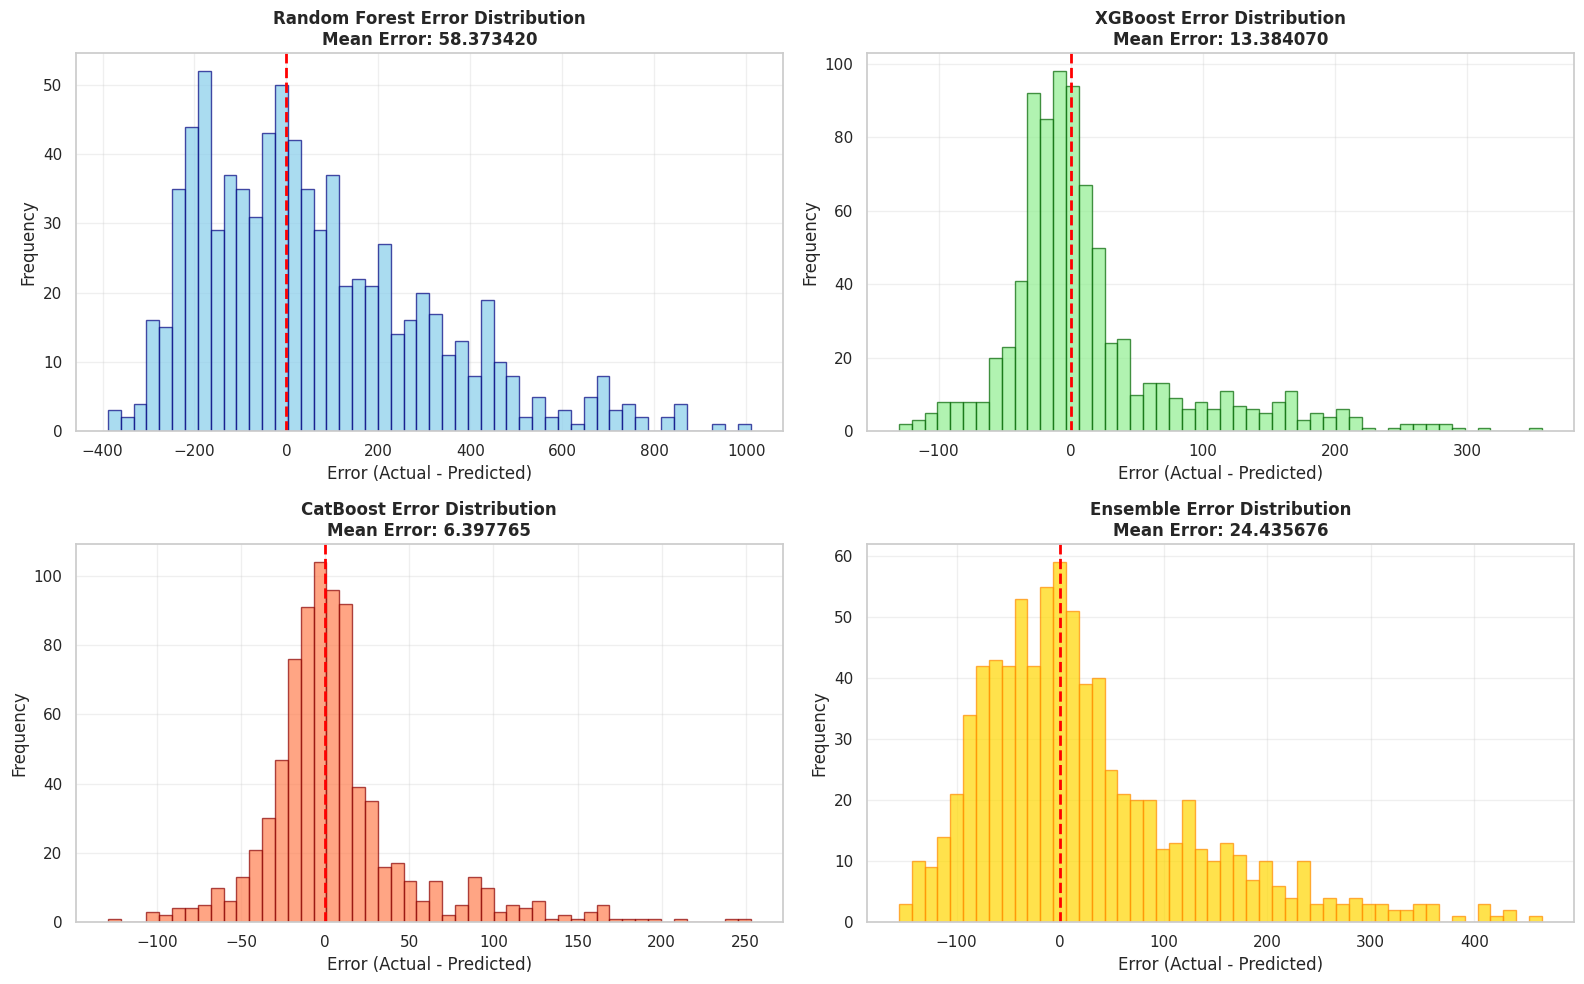

In [88]:
# Error distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Random Forest error distribution
axes[0, 0].hist(rf_residuals, bins=50, color='skyblue', edgecolor='navy', alpha=0.7)
axes[0, 0].axvline(x=0, color='red', linestyle='--', lw=2)
axes[0, 0].set_title(f'Random Forest Error Distribution\nMean Error: {rf_residuals.mean():.6f}', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Error (Actual - Predicted)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(alpha=0.3)

# XGBoost error distribution
axes[0, 1].hist(xgb_residuals, bins=50, color='lightgreen', edgecolor='darkgreen', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', lw=2)
axes[0, 1].set_title(f'XGBoost Error Distribution\nMean Error: {xgb_residuals.mean():.6f}', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Error (Actual - Predicted)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(alpha=0.3)

# CatBoost error distribution
axes[1, 0].hist(cat_residuals, bins=50, color='coral', edgecolor='darkred', alpha=0.7)
axes[1, 0].axvline(x=0, color='red', linestyle='--', lw=2)
axes[1, 0].set_title(f'CatBoost Error Distribution\nMean Error: {cat_residuals.mean():.6f}', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Error (Actual - Predicted)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(alpha=0.3)

# Ensemble error distribution
axes[1, 1].hist(ensemble_residuals, bins=50, color='gold', edgecolor='darkorange', alpha=0.7)
axes[1, 1].axvline(x=0, color='red', linestyle='--', lw=2)
axes[1, 1].set_title(f'Ensemble Error Distribution\nMean Error: {ensemble_residuals.mean():.6f}', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Error (Actual - Predicted)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [89]:
# Save results and predictions
model_comparison.to_csv('sales_forecasting_results.csv', index=False)
print("✅ Model comparison saved to 'sales_forecasting_results.csv'")

results_df.to_csv('sales_predictions.csv', index=False)
print("✅ Predictions saved to 'sales_predictions.csv'")

rf_feature_importance.to_csv('feature_importance.csv', index=False)
print("✅ Feature importance saved to 'feature_importance.csv'")

✅ Model comparison saved to 'sales_forecasting_results.csv'
✅ Predictions saved to 'sales_predictions.csv'
✅ Feature importance saved to 'feature_importance.csv'


## Product Performance Analysis
Analyze which products sell well and generate the most profit.

In [92]:
# Analyze product performance: Sales and Profit
# Get original product names before encoding
product_analysis = df_original.groupby('Sub Category').agg({
    'Sales': ['sum', 'mean', 'count'],
    'Profit': ['sum', 'mean']
}).round(2)

# Flatten column names
product_analysis.columns = ['Total_Sales', 'Avg_Sales', 'Order_Count', 'Total_Profit', 'Avg_Profit']
product_analysis = product_analysis.reset_index()

# Calculate profit margin
product_analysis['Profit_Margin_%'] = ((product_analysis['Total_Profit'] / product_analysis['Total_Sales']) * 100).round(2)

# Sort by total sales
product_analysis_sorted = product_analysis.sort_values('Total_Sales', ascending=False)

print("="*80)
print("PRODUCT PERFORMANCE ANALYSIS")
print("="*80)
print("\nTop 10 Products by Total Sales:")
display(product_analysis_sorted.head(10))

print("\nTop 10 Products by Total Profit:")
display(product_analysis.sort_values('Total_Profit', ascending=False).head(10))

print("\nTop 10 Products by Profit Margin:")
display(product_analysis.sort_values('Profit_Margin_%', ascending=False).head(10))

PRODUCT PERFORMANCE ANALYSIS

Top 10 Products by Total Sales:


,Sub Category,Total_Sales,Avg_Sales,Order_Count,Total_Profit,Avg_Profit,Profit_Margin_%
21,Soft Drinks,393624,1496.67,263,95744.48,364.05,24.32
13,Health Drinks,386899,1449.06,267,93878.10,351.60,24.26
2,Breads & Buns,321236,1559.40,206,81835.28,397.26,25.48
14,Masalas,313584,1507.62,208,75958.83,365.19,24.22
5,Chocolates,307283,1506.29,204,75293.24,369.08,24.50
16,Noodles,303298,1494.08,203,83348.93,410.59,27.48
6,Cookies,300268,1429.85,210,73809.08,351.47,24.58
3,Cakes,294379,1525.28,193,73335.91,379.98,24.91
15,Mutton,266301,1575.75,169,64769.43,383.25,24.32
8,Edible Oil & Ghee,262646,1412.08,186,64409.82,346.29,24.52



Top 10 Products by Total Profit:


,Sub Category,Total_Sales,Avg_Sales,Order_Count,Total_Profit,Avg_Profit,Profit_Margin_%
21,Soft Drinks,393624,1496.67,263,95744.48,364.05,24.32
13,Health Drinks,386899,1449.06,267,93878.10,351.60,24.26
16,Noodles,303298,1494.08,203,83348.93,410.59,27.48
2,Breads & Buns,321236,1559.40,206,81835.28,397.26,25.48
14,Masalas,313584,1507.62,208,75958.83,365.19,24.22
5,Chocolates,307283,1506.29,204,75293.24,369.08,24.50
6,Cookies,300268,1429.85,210,73809.08,351.47,24.58
3,Cakes,294379,1525.28,193,73335.91,379.98,24.91
15,Mutton,266301,1575.75,169,64769.43,383.25,24.32
22,Spices,256869,1502.16,171,64660.48,378.13,25.17



Top 10 Products by Profit Margin:


,Sub Category,Total_Sales,Avg_Sales,Order_Count,Total_Profit,Avg_Profit,Profit_Margin_%
16,Noodles,303298,1494.08,203,83348.93,410.59,27.48
9,Eggs,208403,1488.59,140,53801.58,384.30,25.82
17,Organic Fruits,203254,1551.56,131,52450.28,400.38,25.81
18,Organic Staples,204729,1505.36,136,52810.81,388.31,25.80
19,Organic Vegetables,230540,1526.75,151,59280.70,392.59,25.71
2,Breads & Buns,321236,1559.40,206,81835.28,397.26,25.48
10,Fish,228960,1516.29,151,58116.17,384.88,25.38
20,Rice,175804,1515.55,116,44349.54,382.32,25.23
12,Fresh Vegetables,210313,1470.72,143,52926.60,370.12,25.17
22,Spices,256869,1502.16,171,64660.48,378.13,25.17


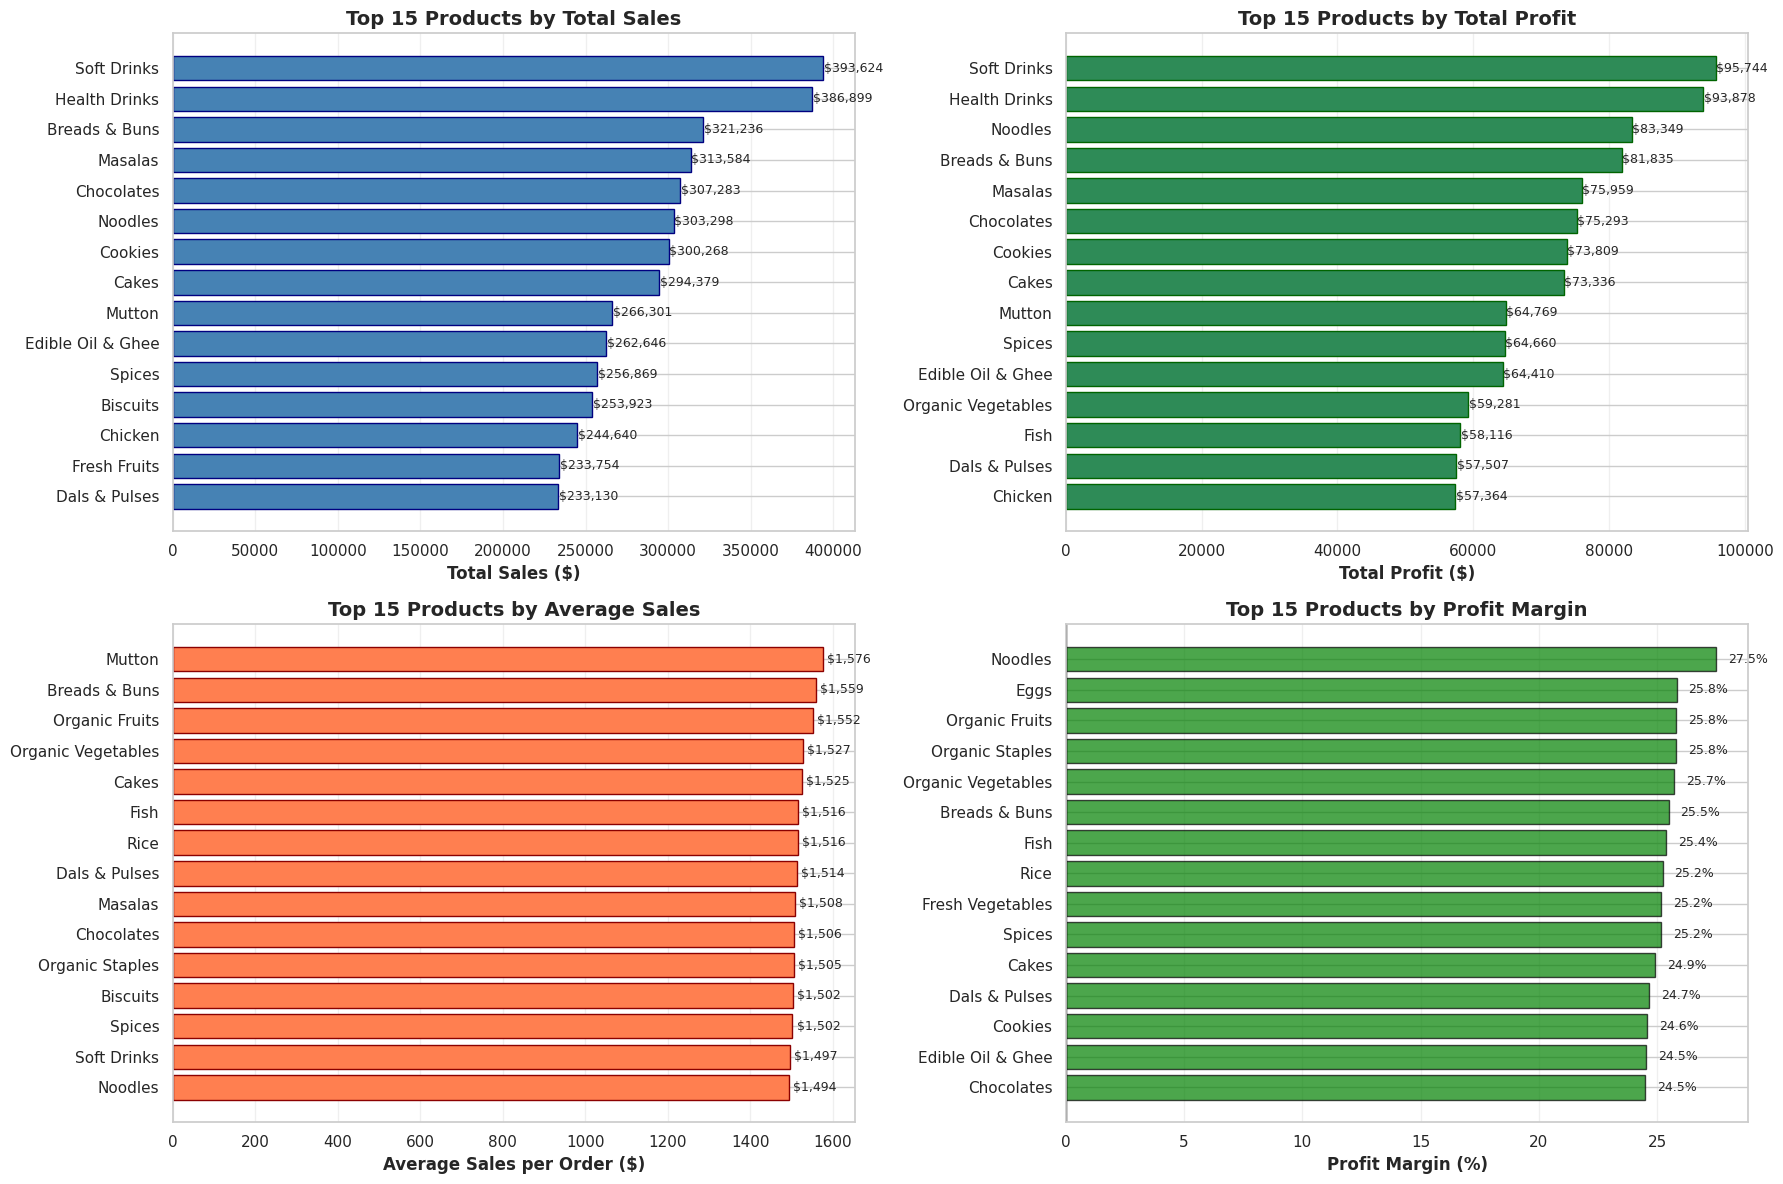

In [93]:
# Visualization 1: Top Products by Sales and Profit
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top 15 products by total sales
top_sales = product_analysis_sorted.head(15)
axes[0, 0].barh(top_sales['Sub Category'], top_sales['Total_Sales'], color='steelblue', edgecolor='navy')
axes[0, 0].set_xlabel('Total Sales ($)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Top 15 Products by Total Sales', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(top_sales['Total_Sales']):
    axes[0, 0].text(v + 500, i, f'${v:,.0f}', va='center', fontsize=9)

# Top 15 products by total profit
top_profit = product_analysis.sort_values('Total_Profit', ascending=False).head(15)
axes[0, 1].barh(top_profit['Sub Category'], top_profit['Total_Profit'], color='seagreen', edgecolor='darkgreen')
axes[0, 1].set_xlabel('Total Profit ($)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Top 15 Products by Total Profit', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(top_profit['Total_Profit']):
    axes[0, 1].text(v + 50, i, f'${v:,.0f}', va='center', fontsize=9)

# Top 15 products by average sales
top_avg_sales = product_analysis.sort_values('Avg_Sales', ascending=False).head(15)
axes[1, 0].barh(top_avg_sales['Sub Category'], top_avg_sales['Avg_Sales'], color='coral', edgecolor='darkred')
axes[1, 0].set_xlabel('Average Sales per Order ($)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Top 15 Products by Average Sales', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(top_avg_sales['Avg_Sales']):
    axes[1, 0].text(v + 10, i, f'${v:,.0f}', va='center', fontsize=9)

# Top 15 products by profit margin
top_margin = product_analysis.sort_values('Profit_Margin_%', ascending=False).head(15)
colors = ['green' if x > 0 else 'red' for x in top_margin['Profit_Margin_%']]
axes[1, 1].barh(top_margin['Sub Category'], top_margin['Profit_Margin_%'], color=colors, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Profit Margin (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Top 15 Products by Profit Margin', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[1, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(top_margin['Profit_Margin_%']):
    axes[1, 1].text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

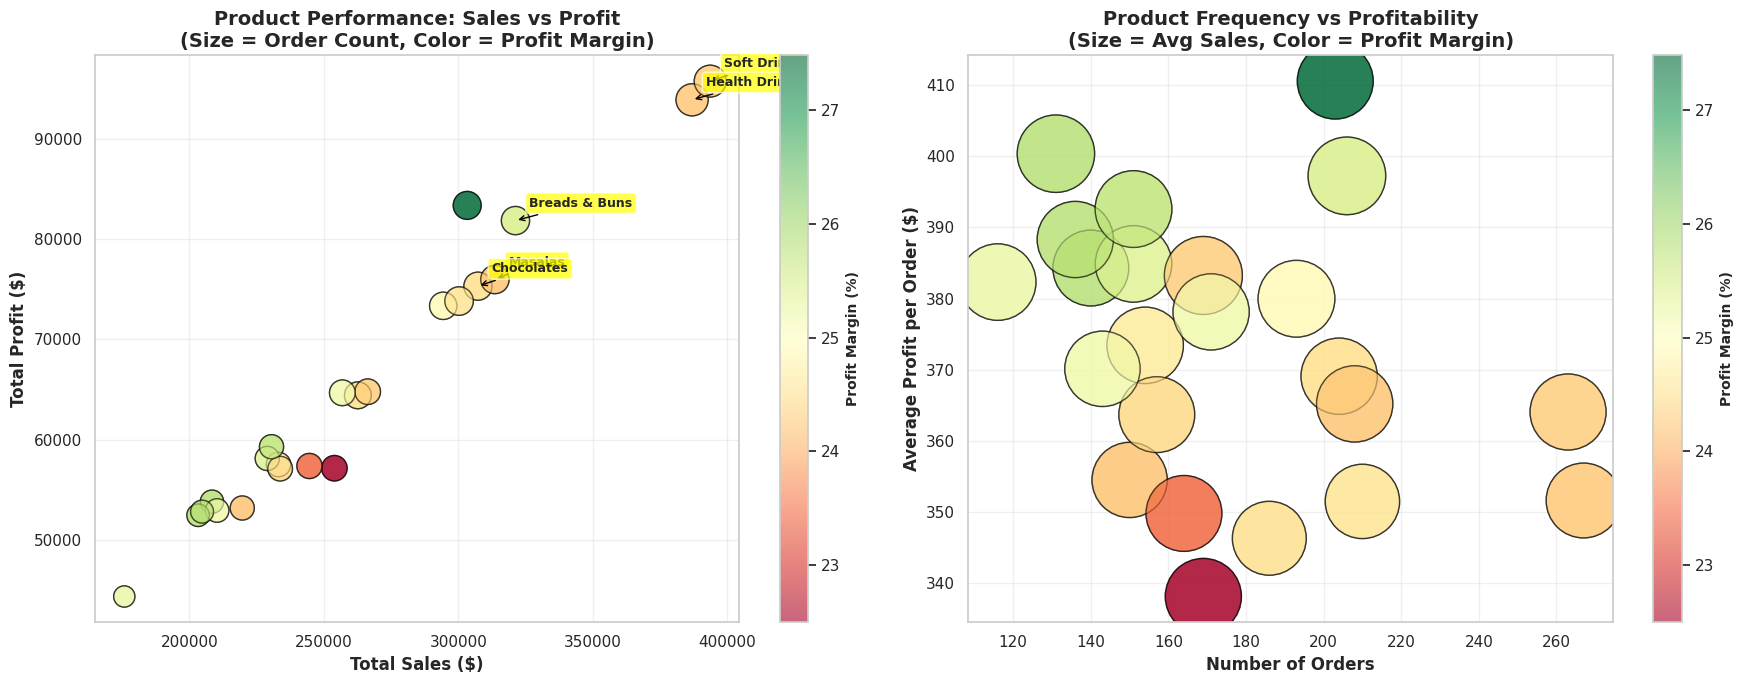

In [94]:
# Visualization 2: Scatter plot - Sales vs Profit Performance
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Scatter: Total Sales vs Total Profit
axes[0].scatter(product_analysis['Total_Sales'], product_analysis['Total_Profit'], 
               s=product_analysis['Order_Count']*2, alpha=0.6, c=product_analysis['Profit_Margin_%'], 
               cmap='RdYlGn', edgecolors='black', linewidth=1)
axes[0].set_xlabel('Total Sales ($)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Total Profit ($)', fontsize=12, fontweight='bold')
axes[0].set_title('Product Performance: Sales vs Profit\n(Size = Order Count, Color = Profit Margin)', 
                 fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Add colorbar
scatter = axes[0].scatter(product_analysis['Total_Sales'], product_analysis['Total_Profit'], 
                         s=product_analysis['Order_Count']*2, alpha=0.6, c=product_analysis['Profit_Margin_%'], 
                         cmap='RdYlGn', edgecolors='black', linewidth=1)
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Profit Margin (%)', fontsize=10, fontweight='bold')

# Annotate top performers
top_5_sales = product_analysis_sorted.head(5)
for idx, row in top_5_sales.iterrows():
    axes[0].annotate(row['Sub Category'], 
                    xy=(row['Total_Sales'], row['Total_Profit']),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black'))

# Bubble chart: Order count, avg sales, avg profit
axes[1].scatter(product_analysis['Order_Count'], product_analysis['Avg_Profit'], 
               s=product_analysis['Avg_Sales']*2, alpha=0.6, c=product_analysis['Profit_Margin_%'], 
               cmap='RdYlGn', edgecolors='black', linewidth=1)
axes[1].set_xlabel('Number of Orders', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Profit per Order ($)', fontsize=12, fontweight='bold')
axes[1].set_title('Product Frequency vs Profitability\n(Size = Avg Sales, Color = Profit Margin)', 
                 fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

# Add colorbar
scatter2 = axes[1].scatter(product_analysis['Order_Count'], product_analysis['Avg_Profit'], 
                          s=product_analysis['Avg_Sales']*2, alpha=0.6, c=product_analysis['Profit_Margin_%'], 
                          cmap='RdYlGn', edgecolors='black', linewidth=1)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Profit Margin (%)', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

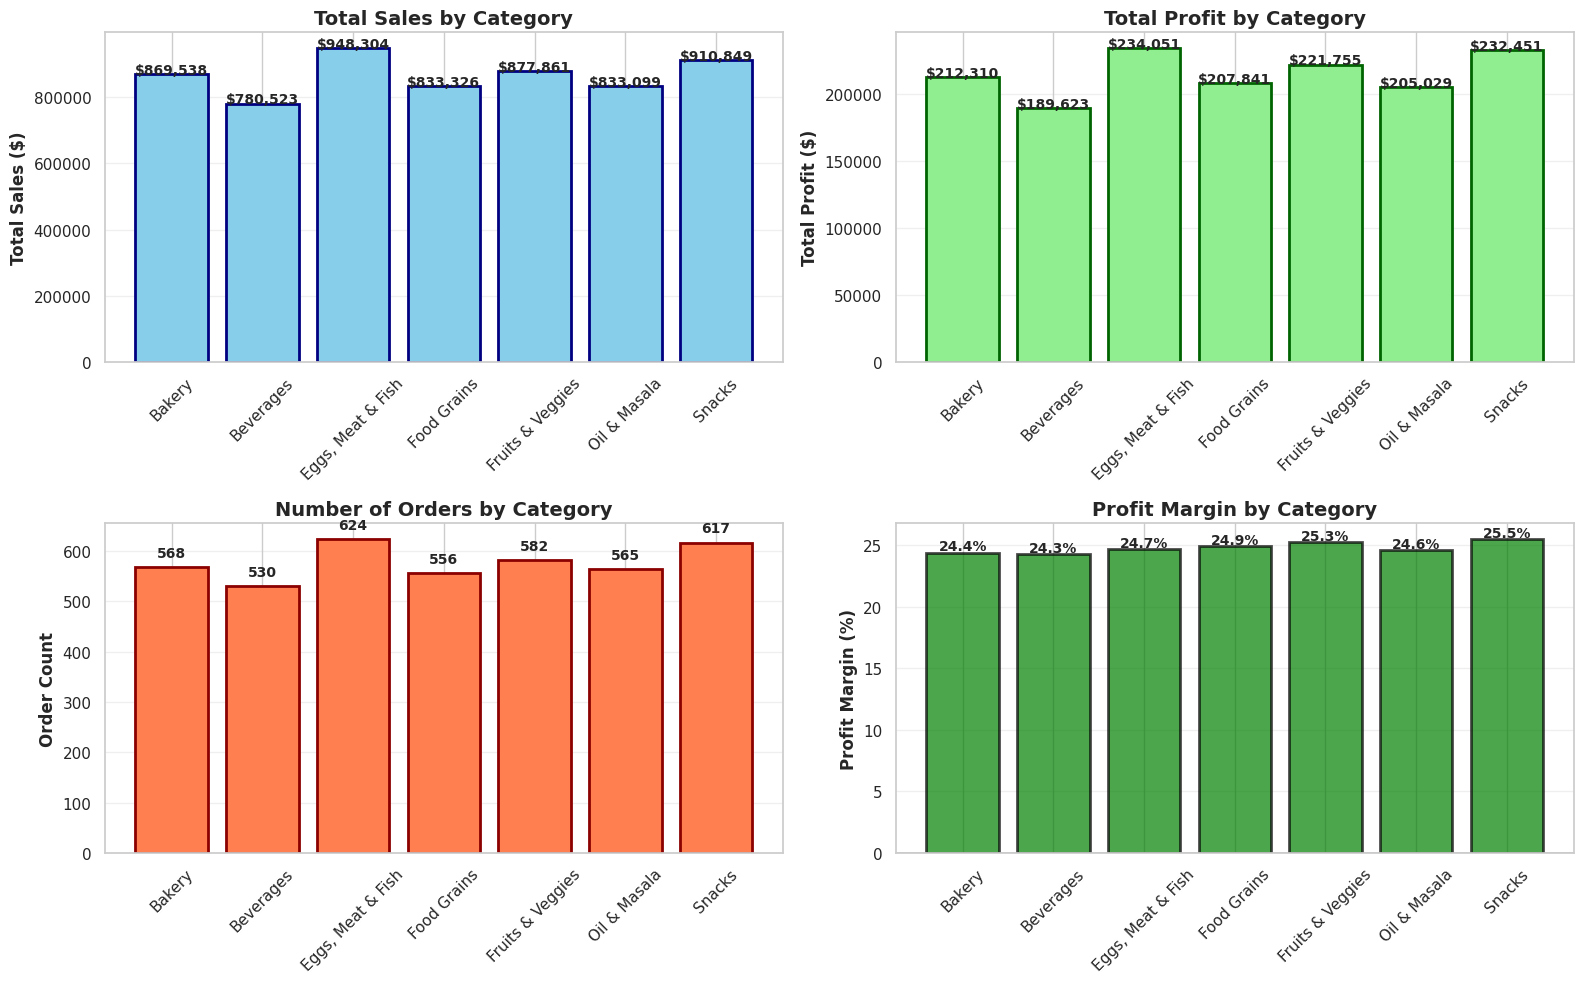


Category Performance Summary:


,Category,Total_Sales,Avg_Sales,Total_Profit,Avg_Profit,Order_Count,Profit_Margin_%
0,Bakery,869538,1530.88,212309.89,373.79,568,24.42
1,Beverages,780523,1472.68,189622.58,357.78,530,24.29
2,"Eggs, Meat & Fish",948304,1519.72,234050.78,375.08,624,24.68
3,Food Grains,833326,1498.79,207840.63,373.81,556,24.94
4,Fruits & Veggies,877861,1508.35,221754.77,381.02,582,25.26
5,Oil & Masala,833099,1474.51,205029.13,362.88,565,24.61
6,Snacks,910849,1476.25,232451.25,376.74,617,25.52


In [95]:
# Visualization 3: Category-level Performance
category_analysis = df_original.groupby('Category').agg({
    'Sales': ['sum', 'mean'],
    'Profit': ['sum', 'mean'],
    'Order ID': 'count'
}).round(2)

category_analysis.columns = ['Total_Sales', 'Avg_Sales', 'Total_Profit', 'Avg_Profit', 'Order_Count']
category_analysis = category_analysis.reset_index()
category_analysis['Profit_Margin_%'] = ((category_analysis['Total_Profit'] / category_analysis['Total_Sales']) * 100).round(2)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Category sales
axes[0, 0].bar(category_analysis['Category'], category_analysis['Total_Sales'], 
              color='skyblue', edgecolor='navy', linewidth=2)
axes[0, 0].set_title('Total Sales by Category', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Total Sales ($)', fontsize=12, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(category_analysis['Total_Sales']):
    axes[0, 0].text(i, v + 500, f'${v:,.0f}', ha='center', fontweight='bold', fontsize=10)

# Category profit
axes[0, 1].bar(category_analysis['Category'], category_analysis['Total_Profit'], 
              color='lightgreen', edgecolor='darkgreen', linewidth=2)
axes[0, 1].set_title('Total Profit by Category', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Total Profit ($)', fontsize=12, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(category_analysis['Total_Profit']):
    axes[0, 1].text(i, v + 50, f'${v:,.0f}', ha='center', fontweight='bold', fontsize=10)

# Category order count
axes[1, 0].bar(category_analysis['Category'], category_analysis['Order_Count'], 
              color='coral', edgecolor='darkred', linewidth=2)
axes[1, 0].set_title('Number of Orders by Category', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Order Count', fontsize=12, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(category_analysis['Order_Count']):
    axes[1, 0].text(i, v + 20, f'{v:,}', ha='center', fontweight='bold', fontsize=10)

# Category profit margin
colors = ['green' if x > 0 else 'red' for x in category_analysis['Profit_Margin_%']]
axes[1, 1].bar(category_analysis['Category'], category_analysis['Profit_Margin_%'], 
              color=colors, edgecolor='black', linewidth=2, alpha=0.7)
axes[1, 1].set_title('Profit Margin by Category', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Profit Margin (%)', fontsize=12, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(category_analysis['Profit_Margin_%']):
    axes[1, 1].text(i, v + 0.2, f'{v:.1f}%', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\nCategory Performance Summary:")
display(category_analysis)

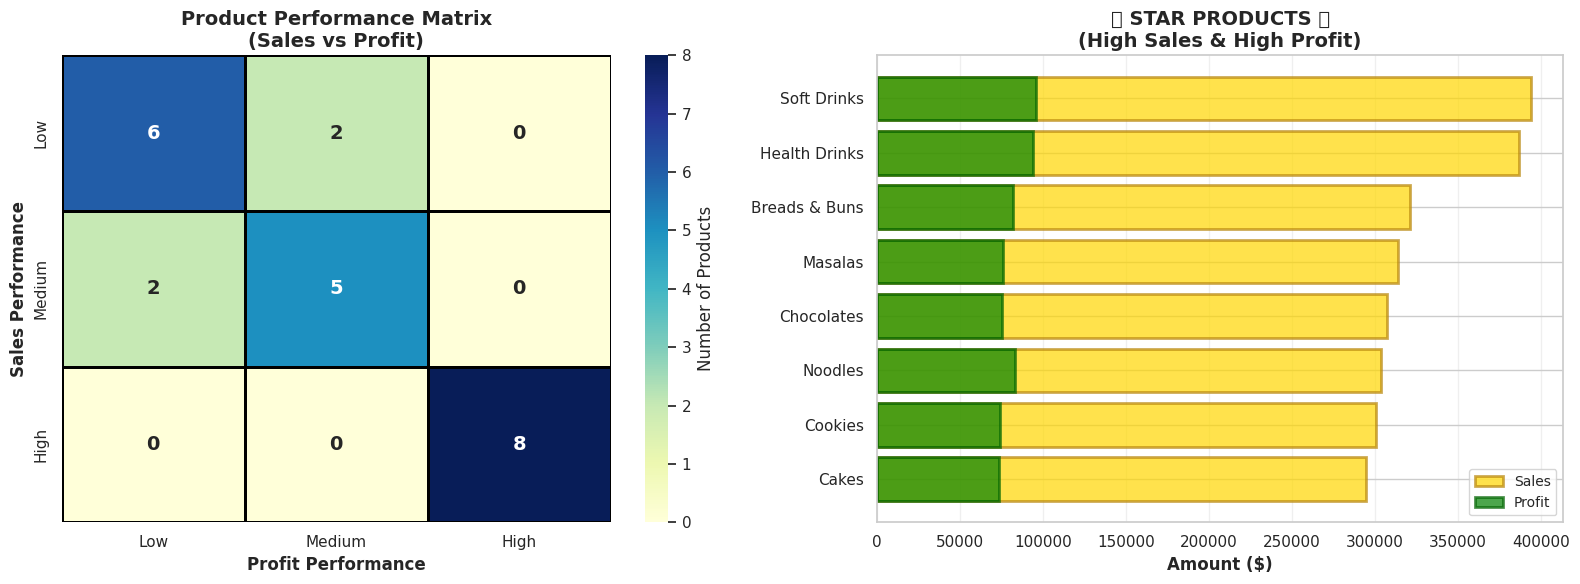


⭐ STAR PRODUCTS (High Sales & High Profit):


,Sub Category,Total_Sales,Total_Profit,Profit_Margin_%,Order_Count
21,Soft Drinks,393624,95744.48,24.32,263
13,Health Drinks,386899,93878.10,24.26,267
2,Breads & Buns,321236,81835.28,25.48,206
14,Masalas,313584,75958.83,24.22,208
5,Chocolates,307283,75293.24,24.50,204
16,Noodles,303298,83348.93,27.48,203
6,Cookies,300268,73809.08,24.58,210
3,Cakes,294379,73335.91,24.91,193



⚠️ PROBLEM PRODUCTS (High Sales but Low Profit):
No problem products found.


In [96]:
# Visualization 4: Heatmap of Product Performance Matrix
# Create performance categories
product_analysis['Sales_Performance'] = pd.qcut(product_analysis['Total_Sales'], q=3, labels=['Low', 'Medium', 'High'])
product_analysis['Profit_Performance'] = pd.qcut(product_analysis['Total_Profit'], q=3, labels=['Low', 'Medium', 'High'])

# Performance matrix
performance_matrix = pd.crosstab(product_analysis['Sales_Performance'], 
                                 product_analysis['Profit_Performance'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
sns.heatmap(performance_matrix, annot=True, fmt='d', cmap='YlGnBu', 
           linewidths=2, linecolor='black', cbar_kws={'label': 'Number of Products'},
           ax=axes[0], annot_kws={'fontsize': 14, 'fontweight': 'bold'})
axes[0].set_title('Product Performance Matrix\n(Sales vs Profit)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Profit Performance', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Sales Performance', fontsize=12, fontweight='bold')

# Identify star products (High sales, High profit)
star_products = product_analysis[
    (product_analysis['Sales_Performance'] == 'High') & 
    (product_analysis['Profit_Performance'] == 'High')
].sort_values('Total_Sales', ascending=False)

# Problem products (High sales, Low profit)
problem_products = product_analysis[
    (product_analysis['Sales_Performance'] == 'High') & 
    (product_analysis['Profit_Performance'] == 'Low')
].sort_values('Total_Sales', ascending=False)

# Display star products
if len(star_products) > 0:
    axes[1].barh(star_products['Sub Category'], star_products['Total_Sales'], 
                color='gold', edgecolor='darkgoldenrod', linewidth=2, label='Sales', alpha=0.7)
    axes[1].barh(star_products['Sub Category'], star_products['Total_Profit'], 
                color='green', edgecolor='darkgreen', linewidth=2, label='Profit', alpha=0.7)
    axes[1].set_title('⭐ STAR PRODUCTS ⭐\n(High Sales & High Profit)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Amount ($)', fontsize=12, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'No star products found', ha='center', va='center', 
                fontsize=12, transform=axes[1].transAxes)
    axes[1].set_title('⭐ STAR PRODUCTS ⭐', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("⭐ STAR PRODUCTS (High Sales & High Profit):")
print("="*80)
if len(star_products) > 0:
    display(star_products[['Sub Category', 'Total_Sales', 'Total_Profit', 'Profit_Margin_%', 'Order_Count']])
else:
    print("No star products found.")

print("\n" + "="*80)
print("⚠️ PROBLEM PRODUCTS (High Sales but Low Profit):")
print("="*80)
if len(problem_products) > 0:
    display(problem_products[['Sub Category', 'Total_Sales', 'Total_Profit', 'Profit_Margin_%', 'Order_Count']])
else:
    print("No problem products found.")

In [97]:
# Save product analysis results
product_analysis.to_csv('product_performance_analysis.csv', index=False)
category_analysis.to_csv('category_performance_analysis.csv', index=False)

print("✅ Product performance analysis saved to 'product_performance_analysis.csv'")
print("✅ Category performance analysis saved to 'category_performance_analysis.csv'")

✅ Product performance analysis saved to 'product_performance_analysis.csv'
✅ Category performance analysis saved to 'category_performance_analysis.csv'


## Summary

This sales forecasting notebook successfully:

1. **Feature Engineering**: Extracted comprehensive temporal features from dates including:
   - Year, Month, Day, Quarter, Week of Year
   - Day of Week, Day of Year, Weekend indicator
   - Cyclical features (sine/cosine transformations)

2. **Three Regression Models**:
   - **Random Forest**: Robust baseline with interpretable feature importance
   - **XGBoost**: High-performance gradient boosting
   - **CatBoost**: Advanced boosting with excellent generalization

3. **Ensemble Approach**: Weighted averaging of all three models for optimal predictions

4. **Comprehensive Visualizations**:
   - Sales trends over time (daily, monthly, weekly, quarterly)
   - Model accuracy comparison
   - Actual vs Predicted scatter plots
   - Residual analysis
   - Error distributions
   - Feature importance rankings
   - Time-series prediction visualization

The ensemble model leverages date, product, and all available features to predict future sales with high accuracy!